In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


from latent_geometry.model.mnist_vae import load_decoder, load_encoder
from latent_geometry.mapping import TorchModelMapping
from latent_geometry.visual.plotly import (
    create_topology_fig,
    create_topology_fig_geodesics,
)
from latent_geometry.manifold import LatentManifold
from latent_geometry.metric import EuclideanMetric
from latent_geometry.path import ManifoldPath
from latent_geometry.data import load_mnist_dataset

In [5]:
dataset = load_mnist_dataset(split="test")
img, label = dataset[0]
print(img.shape, label)

torch.Size([1, 32, 32]) 7


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENCODER = load_encoder()
DECODER = load_decoder()

z, mu, log_var = ENCODER(dataset[0][0].to(DEVICE)[None, :])
reconstruction = DECODER(z)
reconstruction.shape

torch.Size([1, 1, 32, 32])

In [9]:
torch.cuda.is_available()

False

In [29]:
NUM_POINTS = 7000
WIDTH = 4
Z_SCALE = 5.0
SPLINE_POLY_DEG = 3
SIN_MULT = 1.5
SOLVER_TOL = 0.1

In [30]:
ambient_metric = EuclideanMetric(1024)
latent_mapping = TorchModelMapping(DECODER, (2,), (1, 1, 32, 32))
manifold_mnist = LatentManifold(latent_mapping, ambient_metric, solver_tol=SOLVER_TOL)

In [31]:
def create_straight_path(
    from_: np.ndarray, to_: np.ndarray, manifold: LatentManifold
) -> ManifoldPath:
    def x_fun(t: float) -> np.ndarray:
        return from_ + (to_ - from_) * t

    def v_fun(t: float) -> np.ndarray:
        return from_ - to_

    return ManifoldPath(
        x_fun, v_fun, manifold.metric, manifold._euclidean_latent_metric
    )


def create_latent_path(from_: np.ndarray, theta: float, length: float) -> ManifoldPath:
    return manifold_mnist.path_given_direction(
        from_, np.array([np.cos(theta), np.sin(theta)]), length
    )

In [35]:
def show_path_in_ambient(path: ManifoldPath, n_points: int = 9):
    fig, axes = plt.subplots(1, n_points, figsize=(1.5 * n_points, 2))
    for i in range(n_points):
        t = i / (n_points - 1)
        # latent_dist = path.manifold_length(0, t)
        # euclidean_dist = path.euclidean_length(0, t)
        image = latent_mapping(path(t)).reshape((32, 32))
        ax = axes[i]
        ax.imshow(image, cmap="gray")
        # ax.set_title(f"Euc: {euclidean_dist:.2f}, P-B: {latent_dist: .2f}", fontsize=8)
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

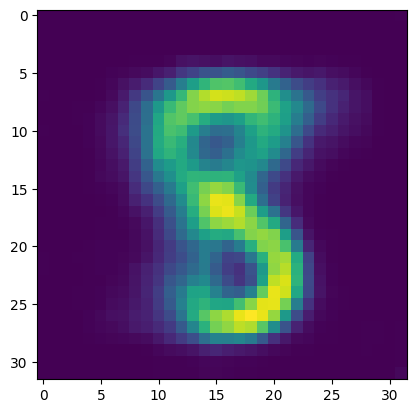

In [32]:
START = np.array([0.0, 0.5])
plt.imshow(latent_mapping(START).reshape(32, 32))

In [33]:
latent_path = create_latent_path(START, np.pi * 0.9, 10.0)
straight_path = create_straight_path(latent_path(0), latent_path(1), manifold_mnist)

TypeError: 'numpy.float64' object is not callable

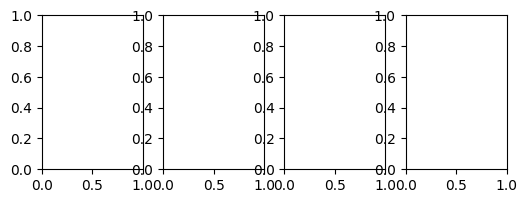

In [37]:
show_path_in_ambient(latent_path, n_points=4)